In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio


In [2]:
# Inicializar Gmsh
gmsh.initialize()

# Abrir archivo .geo
file = "llave.geo"
gmsh.open(file)  # <-- Esta es la clave para cargar la geometría

# Añadir nombre del modelo (opcional si ya está en el archivo)
gmsh.model.setCurrent("llave")

# Sincronizar por si quieres modificar algo en Python
gmsh.model.geo.synchronize()

# Lanzar la interfaz gráfica para visualizar
#gmsh.fltk.run()

# Finalizar Gmsh cuando termines
gmsh.finalize()


Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'


In [3]:
#Establezco el tamaño de la malla
lc = 10

# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
#gmsh.fltk.run()

gmsh.finalize()

Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Circle)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 201 (Circle)
Info    : [ 30%] Meshing curve 202 (Circle)
Info    : [ 30%] Meshing curve 203 (Line)
Info    : [ 30%] Meshing curve 204 (Line)
Info    : [ 40%] Meshing curve 205 (Circle)
Info    : [ 40%] Meshing curve 206 (Circle)
Info    : [ 50%] Meshing curve 207 (Circle)
Info    : [ 50%] Meshing curve 208 (Circle)
Info    : [ 60%] Meshing curve 301 (Line)
Info    : [ 60%] Meshing curve 302 (Line)
Info    : [ 60%] Meshing curve 303 (Circle)
Info    : [ 70%] Meshing curve 304 (Circle)
Info    : [ 70%] Meshing curve 305 (Circle)
Info    : [ 80%] Meshing curve 306 (Line)
Info    : [ 80%] Meshing curve 307 (Line)
Info    : [ 80%] Meshing curve 401 (Line)
Info    : [ 90%] Meshing curve 402 (Line)
Info

In [4]:
import meshio

# Cargar el archivo de malla .msh (versión 4.1 de Gmsh)
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")



Block 0 - Tipo: line, Cantidad: 2, Physical tags: {5}
Block 1 - Tipo: line, Cantidad: 2, Physical tags: {6}
Block 2 - Tipo: line, Cantidad: 3, Physical tags: {7}
Block 3 - Tipo: triangle, Cantidad: 32, Physical tags: {1}
Block 4 - Tipo: triangle, Cantidad: 77, Physical tags: {2}
Block 5 - Tipo: triangle, Cantidad: 27, Physical tags: {3}
Block 6 - Tipo: triangle, Cantidad: 24, Physical tags: {4}


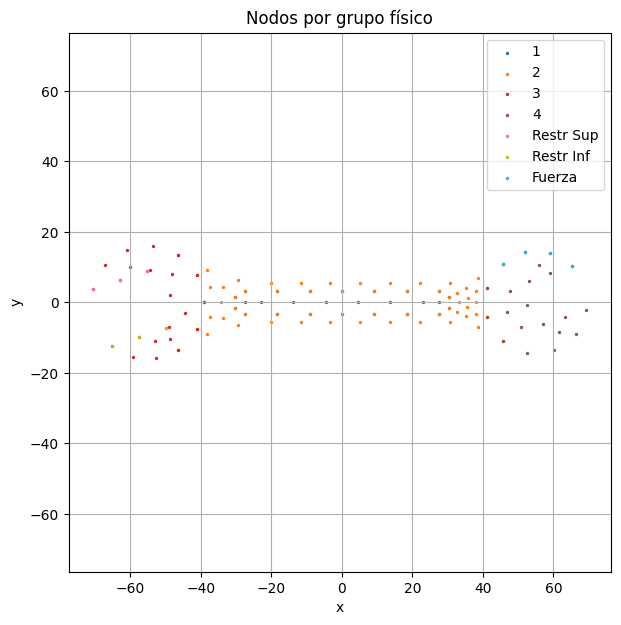

In [5]:
import meshio
from nodes import Node

# Leer archivo .msh
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}

# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id, x, y))

# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = [0, 0]
            if nombre in ["Restr Sup", "Restr Inf"]:
                restrain = [1, 1]
            grupos[nombre].append(Node(node_id, x, y, restrain=restrain))


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())

# Graficar por grupo
Node.plot_nodes_por_grupo(grupos, show_ids=False)


In [6]:
from section import Section

#Ahora creo las 4 secciones posibles
thicknes = {"1": 2.0, "2": 4.0, "3": 5.0, "4": 5.0}
sections = {}

#Defino las propiedades del material

E = 210000
nu = 0.3
rho = 7850

for group in thicknes:
    sections[group] = Section(thicknes[group], E, nu)


In [7]:
nodes_dict = {}
nodes = []
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node
        nodes.append(node)


In [8]:
from cst import CST

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []

for i in range(len(tags)):
    section = sections[str(tags[i])]

    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]]
    nodo_b = nodes_dict[node_ids[1]]
    nodo_c = nodes_dict[node_ids[2]]

    for nodo in [nodo_a, nodo_b, nodo_c]:
        if np.all(nodo.restrain == [1, 1]):
            print(f"Nodo {nodo.id} con restricción total está en elemento {i+1}")

    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section)
    elements.append(elem)




Nodo 64 con restricción total está en elemento 113
Nodo 15 con restricción total está en elemento 114
Nodo 64 con restricción total está en elemento 114
Nodo 63 con restricción total está en elemento 115
Nodo 14 con restricción total está en elemento 115
Nodo 63 con restricción total está en elemento 123
Nodo 17 con restricción total está en elemento 130
Nodo 17 con restricción total está en elemento 131
Nodo 64 con restricción total está en elemento 132
Nodo 17 con restricción total está en elemento 132
Nodo 16 con restricción total está en elemento 134
Nodo 16 con restricción total está en elemento 135
Nodo 16 con restricción total está en elemento 136
Nodo 63 con restricción total está en elemento 136


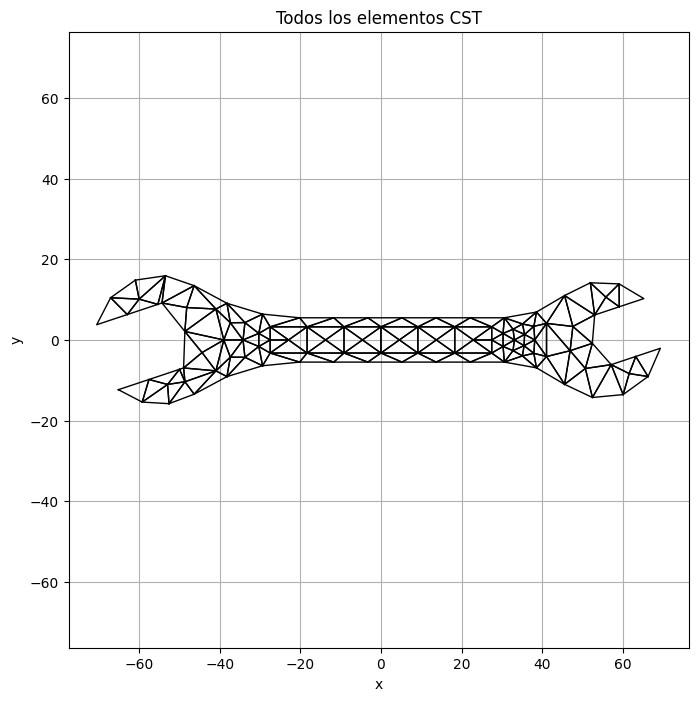

In [9]:
import matplotlib.pyplot as plt

def plot_all_elements(elements, show_ids=True):
    """
    Dibuja todos los elementos CST en una sola figura.

    Parámetros:
    - elements: lista de instancias de CST
    - show_ids: si True, muestra los ID de los nodos y elementos
    """
    plt.figure(figsize=(8, 8))
    
    for elem in elements:
        coords = elem.get_xy_matrix()
        coords = np.vstack([coords, coords[0]])  # cerrar triángulo

        # Dibujar contorno del triángulo
        plt.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        if show_ids:
            # Mostrar ID del elemento en su centroide
            centroid = coords[:-1].mean(axis=0)
            plt.text(centroid[0], centroid[1], str(elem.element_tag), color='red', fontsize=8)


    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.title("Todos los elementos CST")
    plt.show()


plot_all_elements(elements, show_ids=False)

In [10]:
from solve import Solve

estructure = Solve(nodes, elements)

In [ ]:
# Aplicar fuerza vertical arbitraria en el grupo "Fuerza"
if "Fuerza" in grupos:
    nodos_fuerza = grupos["Fuerza"]
    Py_total = -100.0  # N negativos = hacia abajo (puedes cambiarlo)
    f_por_nodo = Py_total / len(nodos_fuerza)

    for nodo in nodos_fuerza:
        dof_y = nodo.id * 2 + 1
        estructure.apply_force(dof_index=dof_y, value=-50.0)  # Por ejemplo, 50 N hacia abajo

In [11]:
desplazamientos = estructure.solve()

N° de DOFs libres: 274
N° de DOFs fijos: 12


LinAlgError: Singular matrix